In [1]:
from PIL import Image
import numpy as np
from einops import rearrange
import torch
import logging

dtype = torch.bfloat16

In [2]:
def rescale_magvit_output(magvit_output):
    """
    [-1, 1] -> [0, 255]

    Important: clip to [0, 255]
    """
    rescaled_output = (magvit_output.detach().cpu() + 1) * 127.5
    clipped_output = torch.clamp(rescaled_output, 0, 255).to(dtype=torch.uint8)
    return clipped_output

In [3]:
pic = Image.open("/home/zhaotang/Pictures/vlcsnap-2024-08-26-17h16m25s357.png")

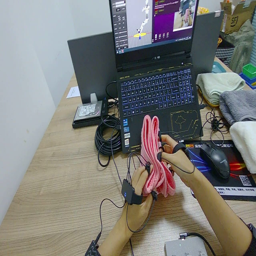

In [4]:
# reshape to 256*256 and convert to numpy
pic = pic.resize((256, 256))
img_numpy = np.array(pic)
pic

In [ ]:
# load MAGVIT
from omegaconf import OmegaConf
from cyber.models.world.autoencoder.magvit2.models.lfqgan import VQModel

magvit2_base_conf = OmegaConf.load("path/to/pretrained/VQGAN/config.yaml")
magvit2_base = VQModel(magvit2_base_conf, ckpt_path="path/to/pretrained/VQGAN/model.ckpt")

In [10]:
# normalize input
img_numpy_norm = img_numpy / 127.5 - 1
img_torch = torch.tensor(img_numpy_norm).permute(2, 0, 1).unsqueeze(0)
magvit2_base.to("cuda", dtype=dtype)
img_torch = img_torch.to("cuda", dtype=dtype)

In [ ]:
# encode img to tokens
with torch.no_grad():
    quant_orig = magvit2_base.encode(img_torch)[0]
    tokens = magvit2_base.quantize.bits_to_indices(quant_orig.permute(0, 2, 3, 1) > 0)

In [19]:
logging.info("tokenized image size\n", tokens.shape)

tokenized image size
 torch.Size([1, 16, 16])


In [23]:
# decode tokens into image
with torch.no_grad():
    quant = magvit2_base.quantize.get_codebook_entry(rearrange(tokens, "b h w -> b (h w)"), bhwc=(*tokens.shape, magvit2_base.quantize.codebook_dim)).flip(1)
    decoded = rescale_magvit_output(magvit2_base.decode(quant.to("cuda", dtype=dtype)))

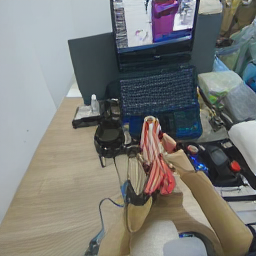

In [24]:
# visualize decoded image
import torchvision.transforms.v2.functional as transforms_f

decoded_rgb = transforms_f.to_pil_image(decoded[0].cpu())
decoded_rgb